## Pre-requirements

In [1]:
!git clone --quiet https://github.com/lllyasviel/ControlNet.git

In [12]:
!pip install -q basicsr==1.4.2 einops==0.6.0 omegaconf==2.3.0 transformers==4.26.1 triton==2.0.0 xformers==0.0.16 open-clip-torch==2.15.0 pytorch-lightning==1.9.4

In [3]:
import sys
if '/content/ControlNet' not in sys.path:
  sys.path.append('/content/ControlNet')

## Import libraries

In [14]:
from share import *
import config

import cv2
import einops
import numpy as np
import torch
import random
from PIL import Image

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.canny import CannyDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

apply_canny = CannyDetector()

## Util definitions

In [15]:
import os
import requests
from tqdm import tqdm

def download_file_with_progress(url, save_path):
    """
    Downloads a file from a URL with a progress bar and saves it to a file path.
    If the path does not exist, it creates the necessary directories before saving the file.

    :param url: URL to download the file from
    :param save_path: File path to save the downloaded file
    """
    # Check if the path exists and create the directories if it doesn't
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Download the file and show a progress bar
    response = requests.get(url, stream=True)
    file_size = int(response.headers.get('content-length', 0))
    block_size = 1024
    progress_bar = tqdm(total=file_size, unit='iB', unit_scale=True)
    progress_bar.set_postfix_str(save_path)
    with open(save_path, 'wb') as f:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            f.write(data)
    progress_bar.close()

def img2img_canny(input_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, low_threshold, high_threshold, device):
    with torch.no_grad():
        img = resize_image(HWC3(input_image), image_resolution)
        H, W, C = img.shape

        detected_map = apply_canny(img, low_threshold, high_threshold)
        detected_map = HWC3(detected_map)

        control = torch.from_numpy(detected_map.copy()).float().to(device) / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples).to(device)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples).to(device)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]
    return [255 - detected_map] + results

In [16]:
control_models = {
    'canny': {
        'url': 'https://huggingface.co/lllyasviel/ControlNet/resolve/main/models/control_sd15_canny.pth',
        'path': '/content/ControlNet/models/control_sd15_canny.pth'
    }
}

## Load model

In [17]:
device = 'cuda' #@param ['cpu', 'cuda'] 

device = torch.device(device)

In [18]:
control_mode = 'canny'

if control_mode not in control_models.keys():
  raise NotImplementedError(f"Not supported control mode: {control_mode}")

model_path = control_models[control_mode]['path']

if not os.path.exists(model_path):
  download_file_with_progress(control_models[control_mode]['url'], model_path)

model = create_model('/content/ControlNet/models/cldm_v15.yaml').to(device)
model.load_state_dict(load_state_dict(model_path, location=device))
model = model.to(device)

ddim_sampler = DDIMSampler(model)

100%|██████████| 5.71G/5.71G [01:56<00:00, 49.1MiB/s, /content/ControlNet/models/control_sd15_canny.pth]
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


ControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_

Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is 768 and using 8 heads.
Setting up Me

## Load image

In [19]:
from google.colab import files

files.upload_file('/content/image.jpg')
input_image = Image.open('/content/image.jpg')
input_image_arr = np.array(input_image)

print('File uploaded.')

Saved emoji_sided_eyes.jpg to /content//content/image.jpg
File uploaded.


In [48]:
#@markdown General parameters
prompt = "wooden" #@param {type: "string"}
a_prompt = "" #@param {type: "string"}
n_prompt = "" #@param {type: "string"}
num_samples = 6 #@param {type: "number"}

#@markdown Canny parameters
canny_low_threshold = 100 #@param {type: "number"}
canny_high_threshold = 200 #@param {type: "number"}

#@markdown Advanced general parameters
image_resolution = 512 #@param {type: "number"}
strength = 1 #@param {type: "number"}
guess_mode = False #@param {type: "boolean"}
ddim_steps = 32 #@param {type: "number"}
scale = 12 #@param {type: "number"}
eta = 0 #@param {type: "number"}
seed = 1000 #@param {type: "number"}

## Run inference

In [49]:
results = img2img_canny(input_image_arr, prompt, a_prompt, n_prompt, num_samples, image_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, canny_low_threshold, canny_high_threshold, device)

INFO:lightning_fabric.utilities.seed:Global seed set to 1000


Data shape for DDIM sampling is (6, 4, 64, 64), eta 0
Running DDIM Sampling with 33 timesteps


DDIM Sampler: 100%|██████████| 33/33 [00:18<00:00,  1.82it/s]


## Show results

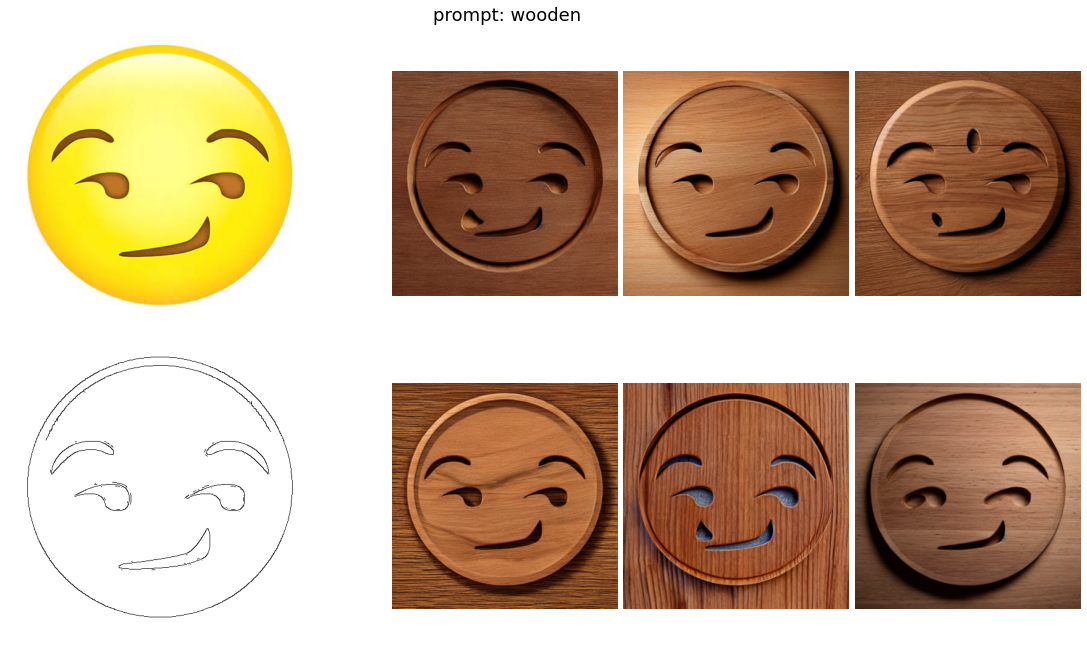

In [50]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

detected_map, outputs = results[0], results[1:]
noutputs = len(outputs)

ncols = max(noutputs // 2, 3)
nrows = max(noutputs // ncols, 2)
fig = plt.figure(constrained_layout=True, figsize=(16, 9))
gs = GridSpec(nrows, ncols + 2, figure=fig)

fig.suptitle(f'prompt: {prompt}', fontsize=18)

ax_main = fig.add_subplot(gs[0, :2])
ax_main.axis('off')
ax_main.imshow(input_image_arr)

ax_control = fig.add_subplot(gs[1, :2])
ax_control.axis('off')
ax_control.imshow(detected_map)

max_size = 312
for idx, output in enumerate(outputs):
  img = Image.fromarray(output)
  w, h = img.size
  scale = max_size / max(h, w)
  img = img.resize((int(w * scale), int(h * scale)))
  axplot = fig.add_subplot(gs[idx // ncols, 2 + idx % ncols])
  axplot.axis('off')
  axplot.imshow(np.array(img))